In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

In [2]:
df_trec = pd.read_parquet("../../../data/metadata_TREC.parquet")

In [3]:
df_trec

,PubYear,url,Authors,Title,Section,filename,filepath,ID
0,2000,http://trec.nist.gov/pubs/trec9/papers/overvie...,"[Ellen M. Voorhees, Donna Harman]",Overview of the Ninth Text REtrieval Conferenc...,Uncategorized,overview_9.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1
1,2000,http://trec.nist.gov/pubs/trec9/papers/trec9-c...,"[Fredric C. Gey, Aitao Chen]",TREC-9 Cross-Language Information Retrieval (E...,Uncategorized,trec9-clir-overview.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_2
2,2000,http://trec.nist.gov/pubs/trec9/papers/filteri...,"[Stephen E. Robertson, David A. Hull]",The TREC-9 Filtering Track Final Report.,Uncategorized,filtering_new.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_3
3,2000,http://trec.nist.gov/pubs/trec9/papers/t9irep.pdf,"[William R. Hersh, Paul Over]",The TREC-9 Interactive Track Report.,Uncategorized,t9irep.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_4
4,2000,http://trec.nist.gov/pubs/trec9/papers/liggett...,"[Walter Liggett, Chris Buckley]",Query Expansion Seen Through Return Order of R...,Uncategorized,liggett.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_5
...,...,...,...,...,...,...,...,...
25,2019,https://trec.nist.gov/pubs/trec28/papers/OVERV...,"[Laura Dietz, John Foley]",TREC CAR Y3: Complex Answer Retrieval Overview,Overview,OVERVIEW.CAR.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1968
26,2007,https://trec.nist.gov/pubs/trec16/papers/umelb...,"[William Webber, Vo Ngoc Anh, Alistair Moffat]",The University of Melbourne in the Million Que...,Participant,umelbourne.ngoc-ahn.MQ.final.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1969
27,2020,https://trec.nist.gov/pubs/trec29/papers/OVERV...,"[Asia J. Biega, Fernando Diaz, Michael D. Ekst...",Overview of the TREC 2020 Fair Ranking Track∗,Overview,OVERVIEW.FR.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1970
28,2017,https://trec.nist.gov/pubs/trec26/papers/NOVAS...,"[Gonçalo Araújo, André Mourão, João Magalhães]",NOVASearch at Precision Medicine 2017,Participant,NOVASearch-PM.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1971


In [4]:
# Urls containing the papers related to the Deep Learning Tracks from 2019 - 2022

link_list = [
"https://pages.nist.gov/trec-browser/trec28/deep/proceedings/",
"https://pages.nist.gov/trec-browser/trec29/deep/proceedings/",
"https://pages.nist.gov/trec-browser/trec30/deep/proceedings/",
"https://pages.nist.gov/trec-browser/trec31/deep/proceedings/"
]

In [5]:
import re
pattern = re.compile(r'trec\d{2}')

# Assigning run names to the corresponding papers
results = []
for i in link_list:
    response = requests.get(i)
    match = pattern.search(i)
    trec_version = match.group()
    soup = BeautifulSoup(response.text, 'html.parser')
    
    h4_tags = soup.find_all('h4')
    
    for h4 in h4_tags:
        next_elements = h4.find_all_next()
        for el in next_elements:
            if el.name == 'p':
                ul_elements = el.find_all_next('ul')
                for ul in ul_elements:
                    if ul.previous_sibling == el or ul.previous_sibling == '\n':
                        strong_tags = ul.find_all_previous('strong')
                        if strong_tags:                  
                            a_tags = ul.find_all('a')
                            pdf_link = None
                            runs = []
                            team_name = None
                            for a in a_tags:
                                href = a.get('href')
                                if 'pdf' in href:
                                    pdf_link = a.get_text()
                                elif "/runs/" in href:
                                    runs.append(a.get_text())
                                elif "/participants/" in href:
                                    team_name = a.get_text()
                            
                            results.append([team_name, pdf_link, runs, trec_version])

In [6]:
participant_df = pd.DataFrame(results, columns=["Team", "URL", "runs", "trec"])

In [7]:
participant_df = participant_df.drop_duplicates(subset=["Team", "URL", "trec"])

In [8]:
participant_df

,Team,URL,runs,trec
0,UCAS,https://trec.nist.gov/pubs/trec28/papers/UCAS....,"[ucas_runid1, ucas_runid2, ucas_runid3]",trec28
1,CMU,https://trec.nist.gov/pubs/trec28/papers/CMU.D...,"[dct_qp_bm25e, dct_tp_bm25e2, dct_tp_bm25e]",trec28
2,TUA1,https://trec.nist.gov/pubs/trec28/papers/TUA1....,[TUA1-1],trec28
3,TU-Vienna,https://trec.nist.gov/pubs/trec28/papers/TU-Vi...,"[TUW19-p2-f, TUW19-p2-re, TUW19-d1-f, TUW19-d1...",trec28
4,CCNU_IRGroup,https://trec.nist.gov/pubs/trec28/papers/CCNU_...,"[runid1, runid2, runid5]",trec28
5,BITEM_DL,https://trec.nist.gov/pubs/trec28/papers/BITEM...,"[baseline, query2doc_RNN]",trec28
6,Microsoft,https://trec.nist.gov/pubs/trec28/papers/Micro...,"[ms_duet, ms_ensemble, ms_duet_passage]",trec28
7,uogTr,https://trec.nist.gov/pubs/trec28/papers/uogTr...,"[uogTrDNN6LM, uogTrDSSQE5LM, uogTrDSS6pLM]",trec28
8,IDST,https://trec.nist.gov/pubs/trec28/papers/IDST....,"[idst_bert_v1, idst_bert_v2, idst_bert_r1, ids...",trec28
9,Brown,https://trec.nist.gov/pubs/trec28/papers/Brown...,[test1],trec28


In [9]:
# Url list containing the websites with the actual results linked to the run names
link_list = [
"https://pages.nist.gov/trec-browser/trec28/deep/results/",
"https://pages.nist.gov/trec-browser/trec29/deep/results/",
"https://pages.nist.gov/trec-browser/trec30/deep/results/",
"https://pages.nist.gov/trec-browser/trec31/deep/results/"
]

In [10]:
results = []
pattern = re.compile(r'trec\d{2}')

decimal_pattern = re.compile(r'^.*?(\d+\.\d+)')
pattern_ndcg_10 = re.compile(r"ndcg_cut_10\s+all\s+(\d+\.\d+)")

# Extract the run name and the corresponding MAP score
for i in link_list:
    response = requests.get(i)
    match = pattern.search(i)
    trec_version = match.group()
    soup = BeautifulSoup(response.text, 'html.parser')
    h4_tags = soup.find_all('h4')

    for h4 in h4_tags:
        details_tags = h4.find_all_next('details')
        
        for details in details_tags:
            summary = details.find('summary')
            if summary and "summary (trec_eval)" in summary.text:
                div = summary.find_next_sibling('div')
                if div:
                    code_tag = div.find('code')
                    if code_tag:
                        code_text = code_tag.get_text(strip=True)
                        print(code_text)
                        match = pattern_ndcg_10.search(code_text)

                        if match:
                            print("Match found")
                            decimal_number = match.group(1)

                            results.append([h4.get_text(strip=True)[:-1], decimal_number, trec_version])
                            break

map             all 0.4723
bpref           all 0.5668
recip_rank      all 0.9690
P_10            all 0.8279
P_100           all 0.3777
P_1000          all 0.0603
recall_10       all 0.1756
recall_100      all 0.5204
recall_1000     all 0.6778
ndcg            all 0.6629
ndcg_cut_10     all 0.7314
ndcg_cut_100    all 0.6348
ndcg_cut_1000   all 0.6629
Match found
map             all 0.3825
bpref           all 0.4612
recip_rank      all 0.9729
P_10            all 0.8000
P_100           all 0.3563
P_1000          all 0.0746
recall_10       all 0.1688
recall_100      all 0.4191
recall_1000     all 0.6182
ndcg            all 0.6255
ndcg_cut_10     all 0.7175
ndcg_cut_100    all 0.6073
ndcg_cut_1000   all 0.6255
Match found
map             all 0.3853
bpref           all 0.4627
recip_rank      all 0.9612
P_10            all 0.8000
P_100           all 0.3663
P_1000          all 0.0749
recall_10       all 0.1641
recall_100      all 0.4298
recall_1000     all 0.6214
ndcg            all 0.6276
ndcg

In [11]:
results

[['TUA1-1', '0.7314', 'trec28'],
 ['idst_bert_v1', '0.7175', 'trec28'],
 ['idst_bert_v2', '0.7181', 'trec28'],
 ['TUW19-p2-f', '0.6709', 'trec28'],
 ['TUW19-p2-re', '0.6615', 'trec28'],
 ['TUW19-d1-f', '0.5383', 'trec28'],
 ['TUW19-d1-re', '0.5930', 'trec28'],
 ['TUW19-p1-f', '0.6756', 'trec28'],
 ['TUW19-p1-re', '0.6746', 'trec28'],
 ['TUW19-p3-f', '0.6884', 'trec28'],
 ['TUW19-p3-re', '0.6746', 'trec28'],
 ['idst_bert_r1', '0.7189', 'trec28'],
 ['idst_bert_r2', '0.7135', 'trec28'],
 ['idst_bert_v3', '0.7257', 'trec28'],
 ['runid1', '0.5164', 'trec28'],
 ['ucas_runid1', '0.6437', 'trec28'],
 ['ucas_runid2', '0.6350', 'trec28'],
 ['idst_bert_p1', '0.7645', 'trec28'],
 ['ucas_runid3', '0.6418', 'trec28'],
 ['baseline', '0.4823', 'trec28'],
 ['idst_bert_p2', '0.7632', 'trec28'],
 ['idst_bert_p3', '0.7594', 'trec28'],
 ['TUW19-d2-f', '0.5596', 'trec28'],
 ['TUW19-d2-re', '0.6053', 'trec28'],
 ['idst_bert_pr1', '0.7378', 'trec28'],
 ['TUW19-d3-f', '0.5576', 'trec28'],
 ['TUW19-d3-re', '0.6

In [12]:
# Assign the run results (NDCG@10 score) by run names to the papers
run_results_per_paper = []
for i,j in participant_df.iterrows():
    result_list = []
    for k in j["runs"]:
        for l in results:
            if k in l and j["trec"] in l:
                result_list.append(l[1])
                break
    run_results_per_paper.append(result_list)

In [13]:
run_results_per_paper

[['0.6437', '0.6350', '0.6418'],
 ['0.5435', '0.5544', '0.5424'],
 ['0.7314'],
 ['0.6709',
  '0.6615',
  '0.5383',
  '0.5930',
  '0.6756',
  '0.6746',
  '0.6884',
  '0.6746',
  '0.5596',
  '0.6053',
  '0.5576',
  '0.6443'],
 ['0.5164', '0.5322', '0.5252'],
 ['0.4823', '0.0534'],
 ['0.5330', '0.5784', '0.6137'],
 ['0.6046', '0.5386', '0.5323'],
 ['0.7175',
  '0.7181',
  '0.7189',
  '0.7135',
  '0.7257',
  '0.7645',
  '0.7632',
  '0.7594',
  '0.7378',
  '0.7379'],
 ['0.7314'],
 ['0.6975', '0.7028'],
 ['0.5239', '0.5283', '0.5063'],
 ['0.6740', '0.6768', '0.6790'],
 ['0.6623', '0.6528', '0.6322'],
 ['0.6856', '0.3710', '0.3990', '0.5597', '0.5280', '0.5431'],
 ['0.6671', '0.6715', '0.6796'],
 ['0.5520'],
 ['0.5791', '0.5453', '0.5476'],
 ['0.5223', '0.5273', '0.6996'],
 ['0.6563',
  '0.6466',
  '0.6504',
  '0.6644',
  '0.6557',
  '0.5734',
  '0.5390',
  '0.5846',
  '0.5455',
  '0.6031',
  '0.5907'],
 ['0.5871', '0.5927', '0.5852', '0.5749'],
 ['0.5990', '0.5339', '0.3878'],
 ['0.6295', '0

In [14]:
participant_df["results"] = run_results_per_paper

In [15]:
participant_df

,Team,URL,runs,trec,results
0,UCAS,https://trec.nist.gov/pubs/trec28/papers/UCAS....,"[ucas_runid1, ucas_runid2, ucas_runid3]",trec28,"[0.6437, 0.6350, 0.6418]"
1,CMU,https://trec.nist.gov/pubs/trec28/papers/CMU.D...,"[dct_qp_bm25e, dct_tp_bm25e2, dct_tp_bm25e]",trec28,"[0.5435, 0.5544, 0.5424]"
2,TUA1,https://trec.nist.gov/pubs/trec28/papers/TUA1....,[TUA1-1],trec28,[0.7314]
3,TU-Vienna,https://trec.nist.gov/pubs/trec28/papers/TU-Vi...,"[TUW19-p2-f, TUW19-p2-re, TUW19-d1-f, TUW19-d1...",trec28,"[0.6709, 0.6615, 0.5383, 0.5930, 0.6756, 0.674..."
4,CCNU_IRGroup,https://trec.nist.gov/pubs/trec28/papers/CCNU_...,"[runid1, runid2, runid5]",trec28,"[0.5164, 0.5322, 0.5252]"
5,BITEM_DL,https://trec.nist.gov/pubs/trec28/papers/BITEM...,"[baseline, query2doc_RNN]",trec28,"[0.4823, 0.0534]"
6,Microsoft,https://trec.nist.gov/pubs/trec28/papers/Micro...,"[ms_duet, ms_ensemble, ms_duet_passage]",trec28,"[0.5330, 0.5784, 0.6137]"
7,uogTr,https://trec.nist.gov/pubs/trec28/papers/uogTr...,"[uogTrDNN6LM, uogTrDSSQE5LM, uogTrDSS6pLM]",trec28,"[0.6046, 0.5386, 0.5323]"
8,IDST,https://trec.nist.gov/pubs/trec28/papers/IDST....,"[idst_bert_v1, idst_bert_v2, idst_bert_r1, ids...",trec28,"[0.7175, 0.7181, 0.7189, 0.7135, 0.7257, 0.764..."
9,Brown,https://trec.nist.gov/pubs/trec28/papers/Brown...,[test1],trec28,[0.7314]


In [16]:
# Extract the best run for every paper into another column

participant_df['best results'] = participant_df['results'].apply(lambda x: max(x) if x else None)

In [17]:
# Merge the run results to the original trec DataFrame and drop unrelated TREC papers by inner join

df_trec = pd.merge(df_trec, participant_df, how="inner", left_on="url", right_on="URL")

In [18]:
# Assign citation scores of Semantic Scholar to the papers

def add_SemanticCitations(df, path):
    with open(path, 'r', encoding="utf-8") as file:
        SemanticCitations = json.load(file)
    
    citations_semantic = []
    for i in SemanticCitations:
        try:
            citations_semantic.append([i, SemanticCitations[i]["citationCount"]])
        except:
            print(i)
    df_citations = pd.DataFrame(citations_semantic, columns=["ID", "Citations_semantic"])
    merge = pd.merge(df, df_citations, how="left" , left_on = "ID", right_on="ID")
    return merge

In [19]:
df_trec = add_SemanticCitations(df_trec, "../../../data/SemanticScholar_TREC_additional_metadata.json")

In [20]:
len(df_trec)

47

In [21]:
# Assign citation scores of OpenAlex to the papers

def add_OpenAlexCitations(df, path):
    with open(path, 'r', encoding="utf-8") as file:
        OpenAlexCitations = json.load(file)
    
    citations_OpenAlex = []
    for i in OpenAlexCitations:
        try:
            citations_OpenAlex.append([i, OpenAlexCitations[i]["cited_by_count"]])
        except:
            print(i)
    df_citations = pd.DataFrame(citations_OpenAlex, columns=["ID", "Citations_OpenAlex"])
    merge = pd.merge(df, df_citations, how="left" , left_on = "ID", right_on="ID")
    return merge

In [22]:
df_trec = add_OpenAlexCitations(df_trec, "../../../data/OpenAlex_TREC.json")

In [23]:
len(df_trec)

47

In [24]:
df_trec

,PubYear,url,Authors,Title,Section,filename,filepath,ID,Team,URL,runs,trec,results,best results,Citations_semantic,Citations_OpenAlex
0,2019,https://trec.nist.gov/pubs/trec28/papers/BITEM...,"[Julien Knafou, Matt Jeffryes, Luc Mottin, Dou...",SIB Text Mining at TREC 2019 Deep Learning Tra...,Participant Papers,BITEM_DL.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1678,BITEM_DL,https://trec.nist.gov/pubs/trec28/papers/BITEM...,"[baseline, query2doc_RNN]",trec28,"[0.4823, 0.0534]",0.4823,3,0.0
1,2019,https://trec.nist.gov/pubs/trec28/papers/Brown...,"[George Zerveas, Ruochen Zhang, Leila Kim, Car...",Brown University at TREC Deep Learning 2019.,Participant Papers,Brown.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1680,Brown,https://trec.nist.gov/pubs/trec28/papers/Brown...,[test1],trec28,[0.7314],0.7314,11,0.0
2,2019,https://trec.nist.gov/pubs/trec28/papers/CCNU_...,"[Hao Hu, Junmei Wang, Xinhui Tu, Tingting He]",CCNU_IRGroup @ TREC 2019 Deep Learning Track.,Participant Papers,CCNU_IRGroup.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1685,CCNU_IRGroup,https://trec.nist.gov/pubs/trec28/papers/CCNU_...,"[runid1, runid2, runid5]",trec28,"[0.5164, 0.5322, 0.5252]",0.5322,0,0.0
3,2019,https://trec.nist.gov/pubs/trec28/papers/CMU.D...,"[Zhuyun Dai, Jamie Callan]",An Evaluation of Weakly-Supervised DeepCT in t...,Participant Papers,CMU.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1690,CMU,https://trec.nist.gov/pubs/trec28/papers/CMU.D...,"[dct_qp_bm25e, dct_tp_bm25e2, dct_tp_bm25e]",trec28,"[0.5435, 0.5544, 0.5424]",0.5544,5,2.0
4,2019,https://trec.nist.gov/pubs/trec28/papers/IDST....,"[Ming Yan, Chenliang Li, Chen Wu, Bin Bi, Wei ...",IDST at TREC 2019 Deep Learning Track: Deep Ca...,Participant Papers,IDST.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1708,IDST,https://trec.nist.gov/pubs/trec28/papers/IDST....,"[idst_bert_v1, idst_bert_v2, idst_bert_r1, ids...",trec28,"[0.7175, 0.7181, 0.7189, 0.7135, 0.7257, 0.764...",0.7645,38,18.0
5,2019,https://trec.nist.gov/pubs/trec28/papers/Micro...,"[Bhaskar Mitra, Nick Craswell]",DUET AT TREC 2019 DEEP LEARNING TRACK.,Participant Papers,Microsoft.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1715,Microsoft,https://trec.nist.gov/pubs/trec28/papers/Micro...,"[ms_duet, ms_ensemble, ms_duet_passage]",trec28,"[0.5330, 0.5784, 0.6137]",0.6137,7,NaN
6,2019,https://trec.nist.gov/pubs/trec28/papers/TU-Vi...,"[Sebastian Hofstätter, Markus Zlabinger, Allan...",TU Wien @ TREC Deep Learning '19 - Simple Cont...,Participant Papers,TU-Vienna.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1725,TU-Vienna,https://trec.nist.gov/pubs/trec28/papers/TU-Vi...,"[TUW19-p2-f, TUW19-p2-re, TUW19-d1-f, TUW19-d1...",trec28,"[0.6709, 0.6615, 0.5383, 0.5930, 0.6756, 0.674...",0.6884,15,9.0
7,2019,https://trec.nist.gov/pubs/trec28/papers/TUA1....,"[Yun Gao, Xin Kang, Fuji Ren, Haitao Yu]",TUA1 at the TREC 2019: Deep Learning Track.,Participant Papers,TUA1.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1726,TUA1,https://trec.nist.gov/pubs/trec28/papers/TUA1....,[TUA1-1],trec28,[0.7314],0.7314,0,0.0
8,2019,https://trec.nist.gov/pubs/trec28/papers/UCAS....,"[Xuanang Chen, Canjia Li, Ben He, Yingfei Sun]",UCAS at TREC-2019 Deep Learning Track.,Participant Papers,UCAS.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1728,UCAS,https://trec.nist.gov/pubs/trec28/papers/UCAS....,"[ucas_runid1, ucas_runid2, ucas_runid3]",trec28,"[0.6437, 0.6350, 0.6418]",0.6437,5,1.0
9,2019,https://trec.nist.gov/pubs/trec28/papers/udel_...,"[Di Zhao, Hui Fang]",Higway BERT for Passage Ranking.,Participant Papers,udel_fang.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1730,udel_fang,https://trec.nist.gov/pubs/trec28/papers/udel_...,"[runid3, runid4]",trec28,"[0.6975, 0.7028]",0.7028,0,0.0


In [25]:
df_trec['best results'] = pd.to_numeric(df_trec['best results'], errors='coerce')

In [26]:
df_trec['ndcg_rank'] = df_trec.groupby('trec')['best results'].rank(ascending=False, method='min')

In [27]:
df_trec

,PubYear,url,Authors,Title,Section,filename,filepath,ID,Team,URL,runs,trec,results,best results,Citations_semantic,Citations_OpenAlex,ndcg_rank
0,2019,https://trec.nist.gov/pubs/trec28/papers/BITEM...,"[Julien Knafou, Matt Jeffryes, Luc Mottin, Dou...",SIB Text Mining at TREC 2019 Deep Learning Tra...,Participant Papers,BITEM_DL.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1678,BITEM_DL,https://trec.nist.gov/pubs/trec28/papers/BITEM...,"[baseline, query2doc_RNN]",trec28,"[0.4823, 0.0534]",0.4823,3,0.0,11.0
1,2019,https://trec.nist.gov/pubs/trec28/papers/Brown...,"[George Zerveas, Ruochen Zhang, Leila Kim, Car...",Brown University at TREC Deep Learning 2019.,Participant Papers,Brown.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1680,Brown,https://trec.nist.gov/pubs/trec28/papers/Brown...,[test1],trec28,[0.7314],0.7314,11,0.0,2.0
2,2019,https://trec.nist.gov/pubs/trec28/papers/CCNU_...,"[Hao Hu, Junmei Wang, Xinhui Tu, Tingting He]",CCNU_IRGroup @ TREC 2019 Deep Learning Track.,Participant Papers,CCNU_IRGroup.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1685,CCNU_IRGroup,https://trec.nist.gov/pubs/trec28/papers/CCNU_...,"[runid1, runid2, runid5]",trec28,"[0.5164, 0.5322, 0.5252]",0.5322,0,0.0,10.0
3,2019,https://trec.nist.gov/pubs/trec28/papers/CMU.D...,"[Zhuyun Dai, Jamie Callan]",An Evaluation of Weakly-Supervised DeepCT in t...,Participant Papers,CMU.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1690,CMU,https://trec.nist.gov/pubs/trec28/papers/CMU.D...,"[dct_qp_bm25e, dct_tp_bm25e2, dct_tp_bm25e]",trec28,"[0.5435, 0.5544, 0.5424]",0.5544,5,2.0,9.0
4,2019,https://trec.nist.gov/pubs/trec28/papers/IDST....,"[Ming Yan, Chenliang Li, Chen Wu, Bin Bi, Wei ...",IDST at TREC 2019 Deep Learning Track: Deep Ca...,Participant Papers,IDST.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1708,IDST,https://trec.nist.gov/pubs/trec28/papers/IDST....,"[idst_bert_v1, idst_bert_v2, idst_bert_r1, ids...",trec28,"[0.7175, 0.7181, 0.7189, 0.7135, 0.7257, 0.764...",0.7645,38,18.0,1.0
5,2019,https://trec.nist.gov/pubs/trec28/papers/Micro...,"[Bhaskar Mitra, Nick Craswell]",DUET AT TREC 2019 DEEP LEARNING TRACK.,Participant Papers,Microsoft.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1715,Microsoft,https://trec.nist.gov/pubs/trec28/papers/Micro...,"[ms_duet, ms_ensemble, ms_duet_passage]",trec28,"[0.5330, 0.5784, 0.6137]",0.6137,7,NaN,7.0
6,2019,https://trec.nist.gov/pubs/trec28/papers/TU-Vi...,"[Sebastian Hofstätter, Markus Zlabinger, Allan...",TU Wien @ TREC Deep Learning '19 - Simple Cont...,Participant Papers,TU-Vienna.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1725,TU-Vienna,https://trec.nist.gov/pubs/trec28/papers/TU-Vi...,"[TUW19-p2-f, TUW19-p2-re, TUW19-d1-f, TUW19-d1...",trec28,"[0.6709, 0.6615, 0.5383, 0.5930, 0.6756, 0.674...",0.6884,15,9.0,5.0
7,2019,https://trec.nist.gov/pubs/trec28/papers/TUA1....,"[Yun Gao, Xin Kang, Fuji Ren, Haitao Yu]",TUA1 at the TREC 2019: Deep Learning Track.,Participant Papers,TUA1.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1726,TUA1,https://trec.nist.gov/pubs/trec28/papers/TUA1....,[TUA1-1],trec28,[0.7314],0.7314,0,0.0,2.0
8,2019,https://trec.nist.gov/pubs/trec28/papers/UCAS....,"[Xuanang Chen, Canjia Li, Ben He, Yingfei Sun]",UCAS at TREC-2019 Deep Learning Track.,Participant Papers,UCAS.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1728,UCAS,https://trec.nist.gov/pubs/trec28/papers/UCAS....,"[ucas_runid1, ucas_runid2, ucas_runid3]",trec28,"[0.6437, 0.6350, 0.6418]",0.6437,5,1.0,6.0
9,2019,https://trec.nist.gov/pubs/trec28/papers/udel_...,"[Di Zhao, Hui Fang]",Higway BERT for Passage Ranking.,Participant Papers,udel_fang.DL.pdf,D:/Studium/Masterarbeit/PythonProject/data/PDF...,trec_1730,udel_fang,https://trec.nist.gov/pubs/trec28/papers/udel_...,"[runid3, runid4]",trec28,"[0.6975, 0.7028]",0.7028,0,0.0,4.0


In [28]:
results = {
    'Year': [],
    'Pearson_corr': [],
    'Pearson_p_value': [],
    'Spearman_corr': [],
    'Spearman_p_value': []
}

# Iterate over every year
for year in df_trec['PubYear'].unique():
    subset = df_trec[df_trec['PubYear'] == year]
    
    pearson_corr, pearson_p = pearsonr(subset['best results'], subset['Citations_semantic'])
    
    spearman_corr, spearman_p = spearmanr(subset['ndcg_rank'], subset['Citations_semantic'])
    
    results['Year'].append(year)
    results['Pearson_corr'].append(pearson_corr)
    results['Pearson_p_value'].append(pearson_p)
    results['Spearman_corr'].append(spearman_corr)
    results['Spearman_p_value'].append(spearman_p)

results_df = pd.DataFrame(results)
print(results_df)

   Year  Pearson_corr  Pearson_p_value  Spearman_corr  Spearman_p_value
0  2019      0.512894         0.106667      -0.387113          0.239517
1  2020      0.192706         0.443610       0.004193          0.986825
2  2021      0.192643         0.593887      -0.367449          0.296223
3  2022     -0.028210         0.947133       0.082479          0.846053


In [30]:
results = {
    'Year': [],
    'Pearson_corr': [],
    'Pearson_p_value': [],
    'Spearman_corr': [],
    'Spearman_p_value': []
}

for year in df_trec['PubYear'].unique():
    subset = df_trec[df_trec['PubYear'] == year]
    
    subset = subset.dropna(subset=['best results', 'ndcg_rank', 'Citations_OpenAlex'])
    
    if len(subset) > 1:  # Pearson und Spearman require atleast 2 data points
        # Pearson-Correlation for best NDCG@10 result and citation rate
        pearson_corr, pearson_p = pearsonr(subset['best results'], subset['Citations_OpenAlex'])
        
        # Spearman-Correlation for ndcg_rank and citation rate
        spearman_corr, spearman_p = spearmanr(subset['ndcg_rank'], subset['Citations_OpenAlex'])
    else:
        pearson_corr, pearson_p = np.nan, np.nan
        spearman_corr, spearman_p = np.nan, np.nan
    
    results['Year'].append(year)
    results['Pearson_corr'].append(pearson_corr)
    results['Pearson_p_value'].append(pearson_p)
    results['Spearman_corr'].append(spearman_corr)
    results['Spearman_p_value'].append(spearman_p)

results_df = pd.DataFrame(results)
print(results_df)

   Year  Pearson_corr  Pearson_p_value  Spearman_corr  Spearman_p_value
0  2019      0.455755         0.185586      -0.195217          0.588868
1  2020     -0.109066         0.666615       0.330883          0.179861
2  2021           NaN              NaN            NaN               NaN
3  2022           NaN              NaN            NaN               NaN


C:\Users\Andreas\AppData\Local\Temp\ipykernel_23012\2655827837.py:20: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(subset['best results'], subset['Citations_OpenAlex'])
C:\Users\Andreas\AppData\Local\Temp\ipykernel_23012\2655827837.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(subset['ndcg_rank'], subset['Citations_OpenAlex'])


C:\Users\Andreas\AppData\Local\Temp\ipykernel_23012\1544427160.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


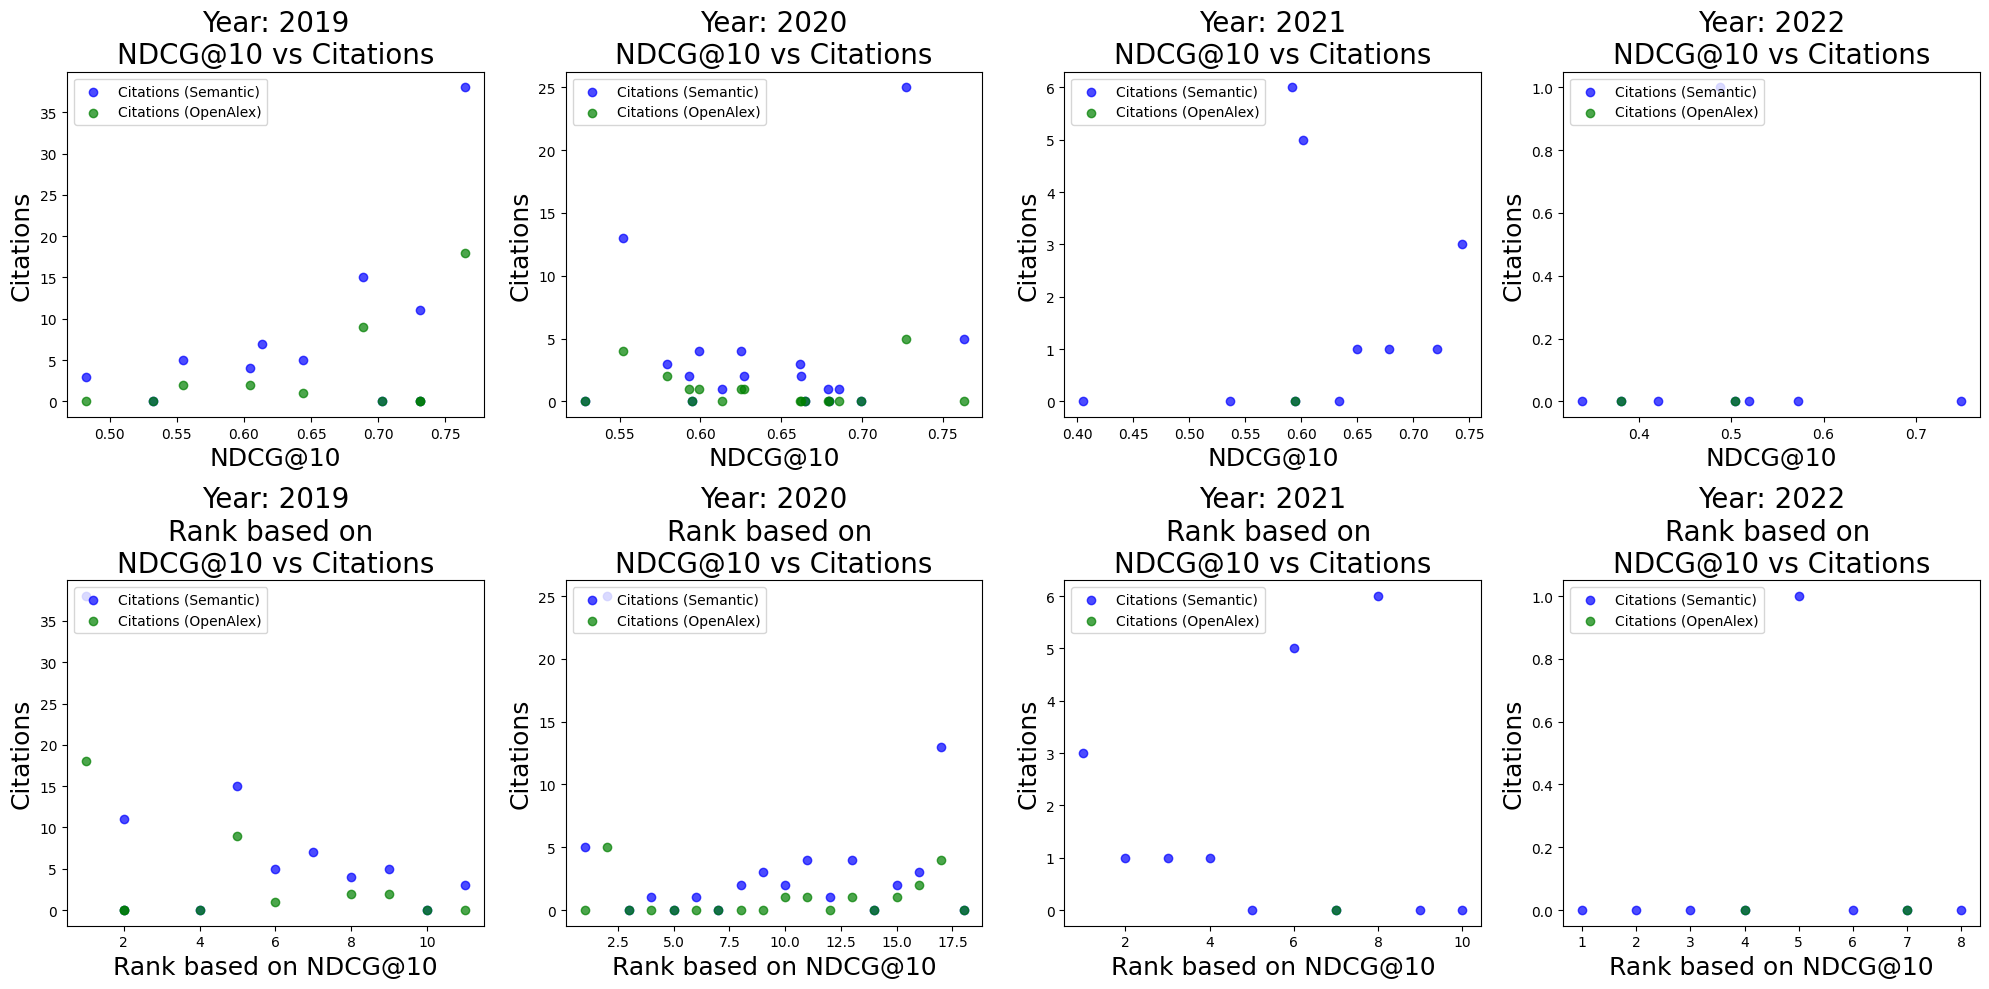

In [31]:
import matplotlib.pyplot as plt

years = sorted(df_trec['PubYear'].unique())
n_years = len(years)

fig, axs = plt.subplots(2, n_years, figsize=(5 * n_years, 10), constrained_layout=True)

for i, year in enumerate(years):
    subset = df_trec[df_trec['PubYear'] == year]
    
    axs[0, i].scatter(subset['best results'], subset['Citations_semantic'], alpha=0.7, label='Citations (Semantic)', color='blue')
    axs[0, i].scatter(subset['best results'], subset['Citations_OpenAlex'], alpha=0.7, label='Citations (OpenAlex)', color='green')
    axs[0, i].set_title(f'Year: {year}\nNDCG@10 vs Citations', fontsize=20)
    axs[0, i].set_xlabel('NDCG@10', fontsize=18)
    axs[0, i].set_ylabel('Citations', fontsize=18)
    axs[0, i].legend(loc='upper left')
    
    axs[1, i].scatter(subset['ndcg_rank'], subset['Citations_semantic'], alpha=0.7, label='Citations (Semantic)', color='blue')
    axs[1, i].scatter(subset['ndcg_rank'], subset['Citations_OpenAlex'], alpha=0.7, label='Citations (OpenAlex)', color='green')
    axs[1, i].set_title(f'Year: {year}\nRank based on \nNDCG@10 vs Citations', fontsize=20)
    axs[1, i].set_xlabel('Rank based on NDCG@10', fontsize=18)
    axs[1, i].set_ylabel('Citations', fontsize=18)
    axs[1, i].legend(loc='upper left')
    
plt.tight_layout()
plt.savefig('../../../images/correlation_citation_result_deep_learning_new.png', dpi=300)  # Save the figure as a PNG file with 300 dpi
plt.show()